<a href="https://colab.research.google.com/github/spacemaninSeoul/justpractice/blob/main/Multi_labelClassClassification_Which_clothes_and_colors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

다중 레이블 분류 문제(Multi-label Class Classification)를 다루도록 한다. 

총 11,385장의 이미지를 메모리에 할당하기엔 무리가 있기 때문에, 제너레이터를 사용하는 방법으로 모델을 학습시킨다. 이미지 제너레이터를 사용하려면 이미지 경로와 해당 레이블을 포함하고 있는 csv 파일이 필요하다. 먼저 csv 파일을 불러온다.    

In [8]:
import os
# os.environ을 이용하여 Kaggle API Username, Key 세팅하기

os.environ ['KAGGLE_USERNAME'] = 'pseudoexaminee'
os.environ ['KAGGLE_KEY'] = '50ef5cd85c486772c23beb302ab99e32'

In [9]:
# 데이터 다운로드 및 압축 해제하기
# Linux 명령어로 Kaggle API를 이용하여 데이터셋 다운로드하기 (!kaggle ~)
# Linux 명령어로 압축 해제하기

!kaggle datasets download -d airplane2230/apparel-image-dataset-2
!unzip '*.zip'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: clothes_dataset/brown_shoes/2d202ed49ac15aeff75681b0d78c322c68852785.jpg  
  inflating: clothes_dataset/brown_shoes/2df99267923b05486744f5fe59ffb9dbf0dce133.jpg  
  inflating: clothes_dataset/brown_shoes/2e94cdf3e3020cad6ad91f01cf75264a270908c6.jpg  
  inflating: clothes_dataset/brown_shoes/2e9ec5a783dd8eb88af84a2fa01dd44ec0837e19.jpg  
  inflating: clothes_dataset/brown_shoes/2ee1746aacd7d31ab3a941934a11b9b34ae884bc.jpg  
  inflating: clothes_dataset/brown_shoes/2f098f41527b7ef3404c1df984f775d21b10df15.jpg  
  inflating: clothes_dataset/brown_shoes/2fbff880bb5d7c001b8993372107a9d06ac44a7f.jpg  
  inflating: clothes_dataset/brown_shoes/3034f61d1f09748763c3e1b0dadd915392b1278b.jpg  
  inflating: clothes_dataset/brown_shoes/30a1704559dec214b60e8bfad6826fdfadf1f87a.jpg  
  inflating: clothes_dataset/brown_shoes/30ef20bcb027c99409c81fd6127957502b0e693e.jpg  
  inflating: clothes_dataset/brown_shoes/312cf581fd4ec3678b8794f9f488aa1dad2f2908.jp

In [17]:
# 데이터 불러오기
import pandas as pd

train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
val_df = pd.read_csv('/content/val.csv')

In [18]:
train_df['image'] = train_df['image'].apply(lambda x: str(x).replace('\\', '/'))
val_df['image'] = val_df['image'].apply(lambda x: str(x).replace('\\', '/'))
test_df['image'] = test_df['image'].apply(lambda x: str(x).replace('\\', '/'))


In [19]:
train_df.head()

,Unnamed: 0,image,black,blue,brown,green,red,white,dress,shirt,pants,shorts,shoes
0,0,./clothes_dataset/blue_shorts/256d854b55ac32ea...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,./clothes_dataset/red_pants/584f778aece14f07c2...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,./clothes_dataset/green_pants/ec543ca241cefb2b...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,./clothes_dataset/brown_shorts/c8db9e0f7010592...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,./clothes_dataset/white_dress/551373c80717c5b0...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [20]:
train_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.drop('Unnamed: 0', axis=1, inplace=True)


In [21]:
val_df.drop('Unnamed: 0', axis=1, inplace=True)


In [22]:
# 이미지 제너레이터를 정의하고 모델 구성
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 제너레이터를 정의한다.
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else :
        return num_samples // batch_size
    
    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
# 입력 데이터의 형태를 꼭 명시해야 한다.
model.add(Flatten(input_shape = (112, 112, 3))) # (112, 112, 3) -> (112 * 112 * 3)
model.add(Dense(128, activation = 'relu')) # 128개의 출력을 가지는 Dense 층
model.add(Dense(64, activation = 'relu')) # 64개의 출력을 가지는 Dense 층
model.add(Dense(11, activation = 'sigmoid')) # 11개의 출력을 가지는 신경망

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['binary_accuracy'])


다중 레이블 문제는 손실 함수로 binary_crossentropy를 사용한다. categorical_crossentropy는 소프트맥스 함수를 사용하여 가장 높은 확률의 클래스만 강조하기에 부적합하다.

케라스는 데이터프레임을 활용하여 학습을 진행할 수 있는 방법(flow_from_dataframe)을 제공하고 있다. 이를 먼저 정의하도록 한다.

In [24]:
# 데이터 제너레이터 정의
batch_size = 32
class_col = ['black', 'blue', 'brown', 'green', 'red', 'white', 'dress', 'shirt', 'pants', 'shorts', 'shoes']

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, 
    directory=None,
    x_col = 'image',
    y_col = class_col,
    target_size = (112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle = True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df, 
    directory=None,
    x_col = 'image',
    y_col = class_col,
    target_size = (112, 112),
    color_mode='rgb',
    class_mode='raw',
    batch_size=batch_size,
    shuffle=True)


Found 5578 validated image filenames.
Found 2391 validated image filenames.


이미지 제너레이터의 flow_from_dataframe() 함수는 데이터프레임을 활용하여 이미지를 불러온다. 사용되는 인자가 많아 헷갈릴 수 있다.
- dataframe : 사용할 데이터프레임을 전달한다.
- directory : 이미지가 존재하는 폴더 경로를 전달한다. 하지만 우리가 사용하는 데이터프레임은 전체 경로를 담고 있기에 따로 전달하지 않는다.
- x_col, y_col : 학습에 사용할 데이터와 레이블이 존재하는 열을 전달한다. 예제 코드에서는 이미지 경로가 존재하는 image와 레이블이 존재하는 class_col을 정의하여 전달하고 있다.
- target_size : 이미지의 크기를 전달받은 크기로 조절한다.
- class_mode : 다중 레이블 문제를 해결하기 위해 raw를 전달한다. 만약 이진 분류라면 binary, 다중 분류라면 categorical을 전달한다.

준비가 다 끝났다. 데이터가 복잡하지 않으므로 학습은 10회 반복한다.

In [25]:
# 제너레이터를 통해 모델 학습시키기
model.fit(train_generator,
         steps_per_epoch=get_steps(len(train_df), batch_size),
         validation_data = val_generator,
         validation_steps=get_steps(len(val_df), batch_size),
         epochs = 10)


Epoch 1/10
175/175 [==============================] - 35s 185ms/step - loss: 0.5489 - binary_accuracy: 0.8498 - val_loss: 0.3305 - val_binary_accuracy: 0.8691
Epoch 2/10
175/175 [==============================] - 33s 186ms/step - loss: 0.2890 - binary_accuracy: 0.8867 - val_loss: 0.2717 - val_binary_accuracy: 0.8948
Epoch 3/10
175/175 [==============================] - 32s 182ms/step - loss: 0.2668 - binary_accuracy: 0.8955 - val_loss: 0.2733 - val_binary_accuracy: 0.8906
Epoch 4/10
175/175 [==============================] - 32s 182ms/step - loss: 0.2349 - binary_accuracy: 0.9068 - val_loss: 0.2546 - val_binary_accuracy: 0.8983
Epoch 5/10
175/175 [==============================] - 32s 182ms/step - loss: 0.2005 - binary_accuracy: 0.9204 - val_loss: 0.2350 - val_binary_accuracy: 0.9073
Epoch 6/10
175/175 [==============================] - 32s 184ms/step - loss: 0.1935 - binary_accuracy: 0.9235 - val_loss: 0.2105 - val_binary_accuracy: 0.9202
Epoch 7/10
175/175 [==========================

학습된 모델을 통해 테스트 데이터를 예측하고, 각 클래스의 확률을 함께 그려보도록 한다. 올바른 예측도 존재하지만, 황당한 예측도 존재한다.

In [27]:
test_datagen = ImageDataGenerator(rescale = 1./255)

# y_col: None, class_mode: None이므로
# test_generator는 image만 반환하고, label은 반환하지 않습니다.
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df, 
    directory=None,
    x_col = 'image',
    y_col = None,
    target_size = (112, 112),
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle = False
)


Found 3416 validated image filenames.


In [28]:
# 책에는 명시되어 있지 않습니다.
preds = model.predict(test_generator,
                      steps = get_steps(len(test_df), batch_size),
                      verbose = 1)


107/107 [==============================] - 73s 131ms/step


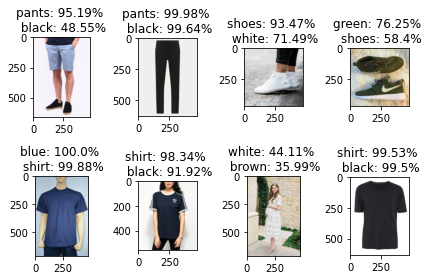

In [30]:
import matplotlib.pyplot as plt
import cv2

# 8개만 예측해보도록 하겠습니다.
do_preds = preds[:8]

for i, pred in enumerate(do_preds):
    plt.subplot(2, 4, i + 1)
    prob = zip(class_col, list(pred))
    # item --> prob
    # contributor: '뱅커'님
    prob = sorted(list(prob), key = lambda z: z[1], reverse = True)[:2]
    
    image = cv2.imread(test_df['image'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image)
    plt.title(f'{prob[0][0]}: {round(prob[0][1] * 100, 2)}% \n {prob[1][0]}: {round(prob[1][1] * 100, 2)}%')
    
plt.tight_layout()
plt.show()